In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re 
import matplotlib as mpl
from jupyter_dash import JupyterDash
import dash
from scipy.stats import linregress


from dash.dependencies import Output, State, Input

# importing curve fit
from scipy.optimize import curve_fit
import matplotlib
from  matplotlib.colors import LinearSegmentedColormap 


In [2]:
path_deep = '../'
#DEAD-Helicase Capflex 
df_dead = pd.read_csv(path_deep + 'NanoClusters/data/capflex_prion/capflex_point_corr.csv') 

In [3]:
df_dead

,3.33 µM L-DNA,6.67 µM L-DNA,13.33 µM L-DNA,26.67 µM L-DNA,33.33 µM L-DNA
0,0.60366,0.81212,1.31190,5.19043,2.06014
1,0.48342,0.51476,0.54998,13.14452,0.36434
2,1.40835,0.70412,0.31170,0.42626,5.44937
3,NaN,0.38277,0.80640,3.60460,0.27427
4,0.64026,0.61356,1.46189,4.47684,2.43541
...,...,...,...,...,...
510,NaN,NaN,NaN,NaN,5.27617
511,NaN,NaN,NaN,NaN,0.07136
512,NaN,NaN,NaN,NaN,-0.11693
513,NaN,NaN,NaN,NaN,0.57240


In [4]:
def k_mom_no_occ(df, conc, conc_list, k):
    column_chosen_idx = conc_list.index(conc)
    matrix_sizes = np.array(df)
    column_chosen = matrix_sizes[:, column_chosen_idx]
    column_chosen = column_chosen[~np.isnan(column_chosen)]
    column_chosen = column_chosen[column_chosen >= 0]
    k_moment = np.mean(column_chosen ** k)
    return k_moment

In [5]:
def k_mom_no_occ_std(df, conc, conc_list, k):
    column_chosen_idx = conc_list.index(conc)
    matrix_sizes = np.array(df)
    column_chosen = matrix_sizes[:, column_chosen_idx]
    column_chosen = column_chosen[~np.isnan(column_chosen)]
    column_chosen = column_chosen[column_chosen >= 0]
    k_moment_std = np.std(column_chosen ** k)
    return k_moment_std

In [6]:
conc_dead = ['3.33', '6.67', '13.33', '26.67', '33.33']

In [7]:
def dict_moment_no_random(df, conc_list, k):
    return {conc: k_mom_no_occ(df, conc, conc_list, k) for conc in conc_list}

def dict_moment_no_random_std(df, conc_list, k):
    return {conc: k_mom_no_occ_std(df, conc, conc_list, k) for conc in conc_list}

In [8]:
k_to_try = [0.5, 1, 1.5, 2]
#critical_c_dead 

k_array_lines_dead = []
#k_array_std_b = []
for k in k_to_try:
    k_mom = dict_moment_no_random(df_dead, conc_dead, k)
    #k_mom_std = dict_moment_std(pappu_b_conc, pappu_b, pappu_b_conc, k)
    k_mom = dict(map(lambda kv: (kv[0], (kv[1])**(-1/k)), k_mom.items()))
    k_array_lines_dead.append(k_mom)
    #k_array_std_b.append(k_mom_std)

In [9]:
colors = ['C0', 'firebrick', 'forestgreen', 'darkviolet']
plt.rc('font', family='Helvetica')

In [10]:
def line(x, a, b):
    return a*x + b

In [11]:
list(map(lambda x: float(x), list(k_array_lines_dead[2].keys())))[1:]

[6.67, 13.33, 26.67, 33.33]

Text(0, 0.5, '$ \\left <  s^{k} \\right >^{-\\dfrac{1}{k}} $')

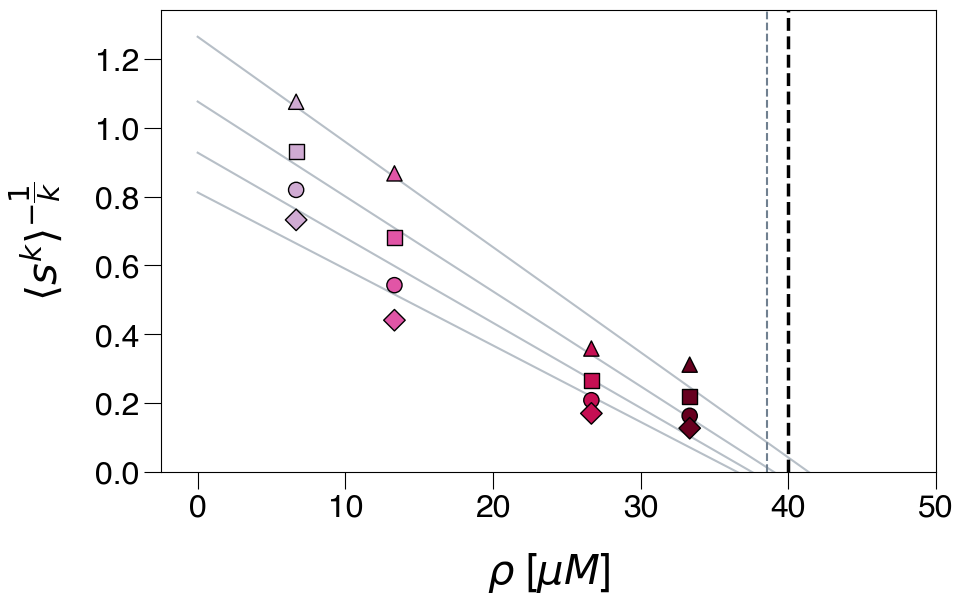

In [13]:
slopes_dead = {}
intercepts_dead = {}
r_dead = {}
se_dead = {}
fig, ax = plt.subplots(figsize=(10, int(10 * 0.65)))
x_axis = np.linspace(0, 50, 1000)
markers = ['^', 's', 'o', 'D']
rho_c_dead_list = []
var_list_dead = []
k_to_try = [0.5, 1, 1.5, 2]
n_colors = len(conc_dead[1:])
cmap = matplotlib.cm.get_cmap('PuRd')
rgba_values = [cmap(np.linspace(0.3, 1, n_colors))[i] for i in range(n_colors)]
dataToSave = pd.DataFrame({'rho':list(map(lambda x: float(x), list(k_array_lines_dead[0].keys())))[1:]})
for i in range(len(k_to_try)):
    ax.scatter(list(map(lambda x: float(x), list(k_array_lines_dead[i].keys())))[1:]\
        , list(k_array_lines_dead[i].values())[1:], label = f'k = {k_to_try[i]}', color = rgba_values, alpha = 1,\
            marker = markers[i], zorder = 4, s = 120, edgecolor = 'black', linewidth = 1)
    dataToSave[f'k = {k_to_try[i]}'] = list(k_array_lines_dead[i].values())[1:]
    slope, intercept, r, _, se = \
    linregress(list(map(lambda x: float(x), list(k_array_lines_dead[i].keys())))[1:],\
    list(k_array_lines_dead[i].values())[1:])
    #print(slope, intercept)
    popt, pcov = curve_fit(line, list(map(lambda x: float(x), list(k_array_lines_dead[i].keys())))[1:],\
    list(k_array_lines_dead[i].values())[1:])
    var_list_dead.append((popt[1]**2 / popt[0]**4) * pcov[0][0] + (1 / popt[1] **2) * pcov[1][1])
    slopes_dead[k_to_try[i]] = slope
    intercepts_dead[k_to_try[i]] = intercept
    
    r_dead[k_to_try[i]] = r
    se_dead[k_to_try[i]] = se
    #ax.axvline(- intercept / slope, linestyle = '--',\
    #    label = 'Inferred Critical concentration', color = 'slategrey')
    rho_c_dead_list.append(- intercept / slope)
    #std_list_dead.append()

    ax.plot(x_axis, slope * x_axis + intercept, label = f'k = {k_to_try[i]} fit', color = 'slategrey',\
        alpha = 0.5)
critical_c_dead = 40
ax.axvline(critical_c_dead, color = 'black', linestyle = '--', label = 'Critical concentration',\
    linewidth = 2.5)

final_rho_c_dead = np.mean(rho_c_dead_list)
ax.axvline(final_rho_c_dead, color = 'slategrey', linestyle = '--')

ax.set_ylim(bottom = 0)
ax.set_xlim(right = 50)
ax.tick_params(axis='both', which='major', labelsize=23, length=12) 
#ax.grid(zorder = 1)
ax.set_xlabel('$\\rho$ [$\mu M$]', fontsize = 30, labelpad=20)
ax.set_ylabel('$ \left <  s^{k} \\right >^{-\dfrac{1}{k}} $', fontsize = 30, labelpad=20)

#ax.legend(facecolor = 'aliceblue', edgecolor = 'black', shadow = True)
#fig.savefig('../../../Desktop/Fig4A.pdf', dpi = 300, facecolor = 'white', bbox_inches = 'tight')
#fig.savefig('../../../Desktop/Fig4A.svg', dpi = 300, facecolor = 'white')

In [14]:
k =  np.sum(1 / np.array(var_list_dead))
y_bar = np.sum(np.array(rho_c_dead_list) / np.array(var_list_dead)  ) / k
print(y_bar, 'pm', np.sqrt(1/k))

38.95469868193041 pm 2.8296773431355575


In [15]:
print(np.mean(rho_c_dead_list))
print(np.std(rho_c_dead_list))
final_rho_c_dead = np.mean(rho_c_dead_list)

38.597501914001825
1.8250552355660132


In [16]:
k_to_try = [0.5, 1, 1.5, 2]

rho_c_dead = 40
ratio_arr_list = []
ratio_arr_original = []
k_mom_list = []
k_mom_1_list = []
k_mom_std = []
k_mom_1_std = []
for k in k_to_try:
    k_mom = dict_moment_no_random(df_dead, conc_dead, k)
    k_mom_list.append(k_mom)
    k_mom_std.append(dict_moment_no_random_std(df_dead, conc_dead, k))
    k_1_mom = dict_moment_no_random(df_dead, conc_dead, k+1)
    k_mom_1_list.append(k_1_mom)
    k_mom_1_std.append(dict_moment_no_random_std(df_dead, conc_dead, k+1))

    k_mom_arr = np.array(list(k_mom.values()))
    k_1_mom_arr = np.array(list(k_1_mom.values()))
    ratio_dict = {np.abs((float(conc) - final_rho_c_dead)/final_rho_c_dead): k_1_mom_arr[i] / k_mom_arr[i] \
        for i, conc in enumerate(conc_dead)}
    ratio_arr_list.append(ratio_dict)
    ratio_dict_or = {np.abs((float(conc) - rho_c_dead)/rho_c_dead): k_1_mom_arr[i] / k_mom_arr[i] \
        for i, conc in enumerate(conc_dead)}
    ratio_arr_original.append(ratio_dict_or)



In [17]:
err_dict = {}
for i in range(len(k_to_try)):
    err_dict[k_to_try[i]] = {}
    for conc in conc_dead:
        
        yerr = np.sqrt( (1 / k_mom_1_list[i][conc])**2 * k_mom_1_std[i][conc] ** 2 +\
            (1 / k_mom_list[i][conc])**2 * k_mom_std[i][conc] ** 2)

        err_dict[k_to_try[i]][conc] = yerr

Text(0, 0.5, '$log( \\dfrac{<s^{k+1}>}{<s^{k}>} )$')

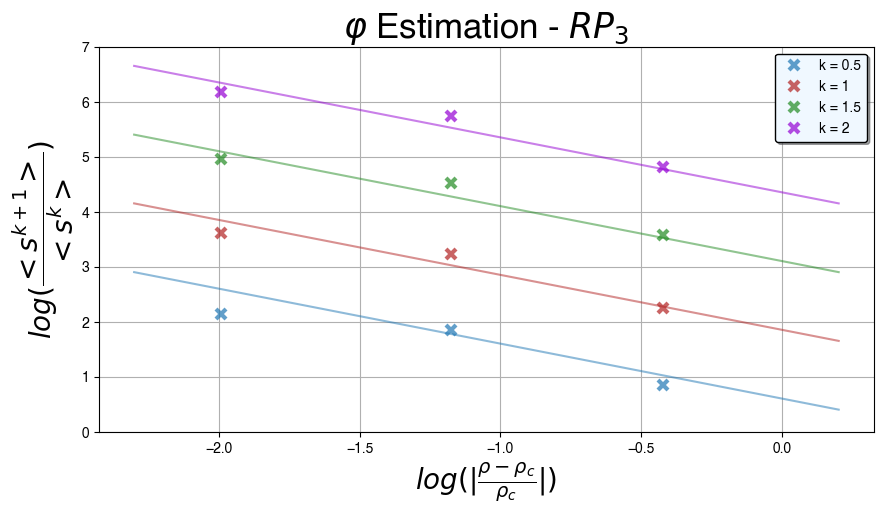

In [18]:
fig, ax = plt.subplots(figsize=(10, 5))
x_axis = np.linspace(-2.3, 0.2, 100)

for i, dict_ in enumerate(ratio_arr_list):
    ax.plot(np.log(np.array(list(dict_.keys())[2:])), np.log(np.exp(i)  * np.array(list(dict_.values())[2:])),\
         'x', label = f'k = {k_to_try[i]}', zorder = 4, color = colors[i], alpha = 0.7,\
            markeredgewidth = 3, markersize = 7)
    ax.plot(x_axis, -1 * x_axis + i/0.8 + 0.6, color = colors[i], zorder = 3, alpha = 0.5)

    
#ax.legend()

ax.grid(zorder = 1)      
ax.set_ylim(bottom = 0, top = 7)

ax.legend(facecolor = 'aliceblue', edgecolor = 'black', shadow = True)
ax.set_title("$ \\varphi$ Estimation - $RP_3$", fontsize=25)  
ax.set_xlabel('$log(| \\frac{\\rho - \\rho_{c}}{\\rho_c}|)$', fontsize = 20)  
ax.set_ylabel('$log( \dfrac{<s^{k+1}>}{<s^{k}>} )$', fontsize=20)


-0.9348965537489095 0.2899047780720447
-0.98170921802363 0.23800780287628093
-0.9895953772413355 0.20546344654039222
-0.9835681758524268 0.20742174451384335
-0.9694161305365674 ± 0.11434548720453037


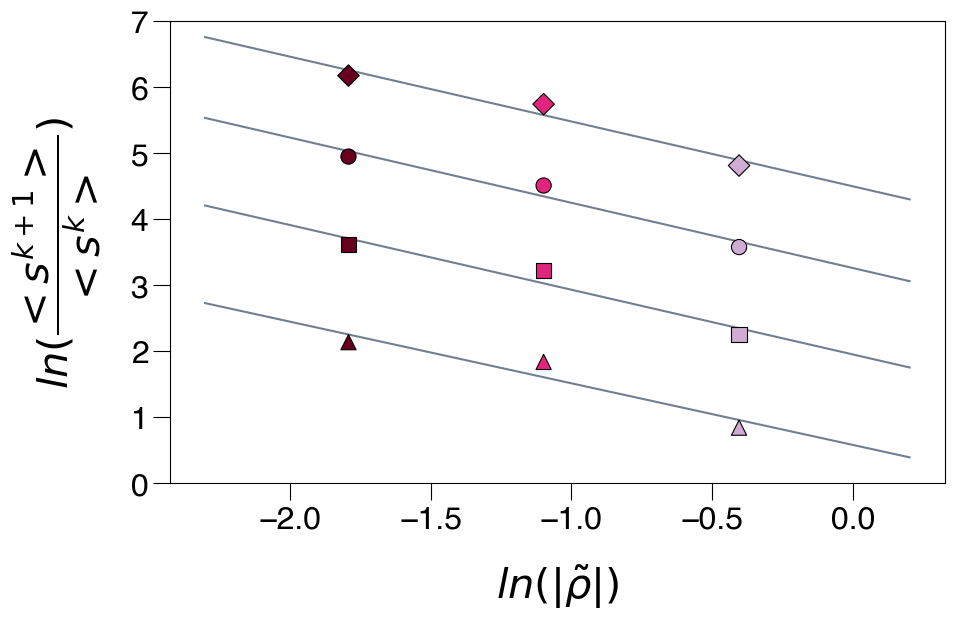

In [19]:
plt.rc('font', family='Helvetica')

#cmap = matplotlib.cm.get_cmap('magma') 
cmap=LinearSegmentedColormap.from_list('rg',['linen',  'sandybrown', 'peru',\
     'chocolate', 'saddlebrown'], N=256) 
import scipy
#cmap=LinearSegmentedColormap.from_list('rg',['ghostwhite', 'aliceblue', 'skyblue', 'cornflowerblue', 'royalblue', 'blue', 'navy', 'black'], N=256) 
#import get_cmap
from matplotlib.cm import get_cmap

#cmap = get_cmap('gist_heat_r') 
cmap=LinearSegmentedColormap.from_list('rg',['hotpink',  'magenta', 'mediumvioletred',\
     'darkmagenta'], N=256) 

n_colors = len(conc_dead[2:])
cmap = matplotlib.cm.get_cmap('PuRd')
rgba_values = [cmap(np.linspace(0.3, 1, n_colors))[i] for i in range(n_colors)]



k_to_try = [0.5, 1, 1.5, 2]


fig, ax = plt.subplots(figsize=(10, int(0.65 * 10)))
x_axis = np.linspace(-2.3, 0.2, 100)
slope_list = []
std_list = []
markers = ['^', 's', 'o', 'D']
for i, dict_ in enumerate(ratio_arr_original):
     ax.scatter(np.log(np.array(list(dict_.keys())[2:])), np.log(np.exp(i)  * np.array(list(dict_.values())[2:])), label = f'k = {k_to_try[i]}', zorder = 4, color = rgba_values, alpha = 1\
        , marker = markers[i], s = 120, edgecolors='black', linewidths = 0.8)
     


     popt, pcov = scipy.optimize.curve_fit(lambda x, a, b: a*x + b, np.log(np.array(list(dict_.keys())[2:])),\
         np.log(np.exp(i)  * np.array(list(dict_.values())[2:]))) 
     slope_list.append(popt[0])
     std_list.append(np.sqrt(pcov[0][0]))
     ax.plot(x_axis, popt[0] * x_axis + popt[1], zorder = 3, alpha = 1, color = 'slategrey')
     print(popt[0], np.sqrt(pcov[0][0]))
    
#ax.legend()

   
ax.set_ylim(bottom = 0, top = 7)

k_alpha = np.sum(1/np.array(std_list)**2)
weighted = np.array(std_list).dot(np.array(slope_list)) / np.sum(std_list)


print(weighted, '±', np.sqrt(1/k_alpha))

#ax.legend(facecolor = 'aliceblue', edgecolor = 'black', shadow = True)
#ax.set_title("$ \\varphi$ Estimation - $RP_3$", fontsize=20, pad = 20)  
ax.set_xlabel('$ln(| \\tilde{\\rho} |)$', fontsize = 30, labelpad = 20)  
ax.set_ylabel('$ln( \dfrac{<s^{k+1}>}{<s^{k}>} )$', fontsize=30, labelpad = 20)
ax.tick_params(axis='both', which='major', labelsize=23, length=12)


#fig.savefig('../../paperPlots/pdfPlots/Fig1A.pdf', dpi = 300, facecolor = 'white', bbox_inches = 'tight')
#fig.savefig('../../paperPlots/svgPlots/Fig1A.svg', dpi = 300, facecolor = 'white', bbox_inches = 'tight')


0.9348965537489095 0.5829741311547897 0.2899047780720447
0.98170921802363 1.953707281199483 0.23800780287628093
0.9895953772413355 3.2630355799914845 0.20546344654039222
0.9835681758524268 4.501116844969361 0.20742174451384335
-0.9694161305365674 ± 0.11434548720453037


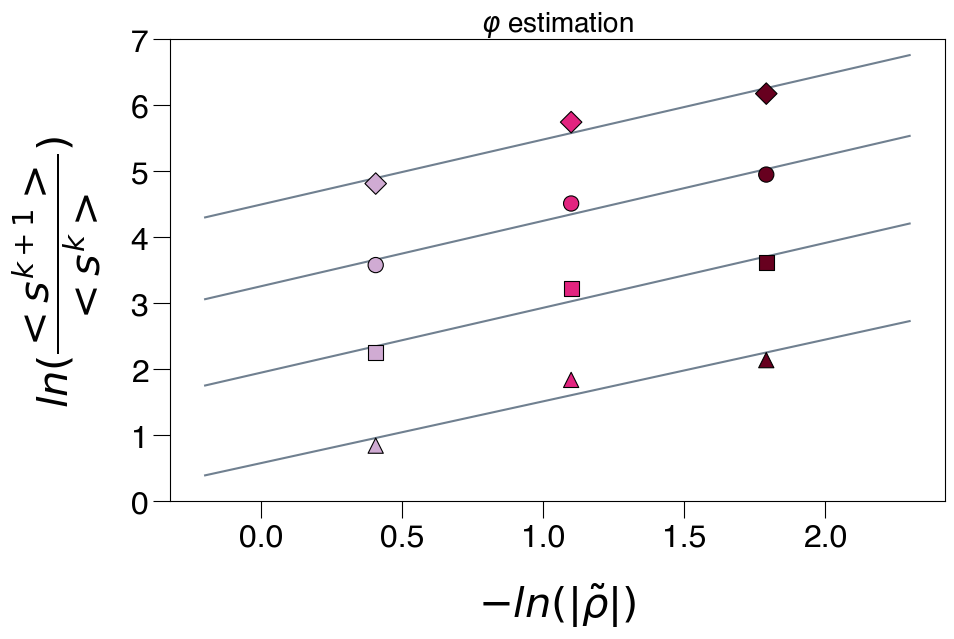

In [21]:
plt.rc('font', family='Helvetica')

#cmap = matplotlib.cm.get_cmap('magma') 
cmap=LinearSegmentedColormap.from_list('rg',['linen',  'sandybrown', 'peru',\
     'chocolate', 'saddlebrown'], N=256) 
import scipy
#cmap=LinearSegmentedColormap.from_list('rg',['ghostwhite', 'aliceblue', 'skyblue', 'cornflowerblue', 'royalblue', 'blue', 'navy', 'black'], N=256) 
#import get_cmap
from matplotlib.cm import get_cmap

#cmap = get_cmap('gist_heat_r') 
cmap=LinearSegmentedColormap.from_list('rg',['hotpink',  'magenta', 'mediumvioletred',\
     'darkmagenta'], N=256) 

n_colors = len(conc_dead[2:])
cmap = matplotlib.cm.get_cmap('PuRd')
rgba_values = [cmap(np.linspace(0.3, 1, n_colors))[i] for i in range(n_colors)]



k_to_try = [0.5, 1, 1.5, 2]


fig, ax = plt.subplots(figsize=(10, int(0.65 * 10)))
x_axis = np.linspace(-2.3, 0.2, 100)
slope_list = []
std_list = []
markers = ['^', 's', 'o', 'D']
dataToSaveX = []
dataToSaveY = []
dataToSave = pd.DataFrame({'ln |tho_tilde|':np.log(np.array(list(dict_.keys())[2:]))})
for i, dict_ in enumerate(ratio_arr_original):
     dataToSave['k = ' + str(k_to_try[i])] = np.log(np.exp(i)  * np.array(list(dict_.values())[2:]))
     
     ax.scatter(-np.log(np.array(list(dict_.keys())[2:])), np.log(np.exp(i)  * np.array(list(dict_.values())[2:])),\
                 label = f'k = {k_to_try[i]}', zorder = 4, color = rgba_values, alpha = 1\
        , marker = markers[i], s = 120, edgecolors='black', linewidths = 0.8)
     


     popt, pcov = scipy.optimize.curve_fit(lambda x, a, b: a*x + b, np.log(np.array(list(dict_.keys())[2:])),\
         np.log(np.exp(i)  * np.array(list(dict_.values())[2:]))) 
     slope_list.append(popt[0])
     std_list.append(np.sqrt(pcov[0][0]))
     ax.plot(-x_axis, popt[0] * x_axis + popt[1], zorder = 3, alpha = 1, color = 'slategrey')
     print(-popt[0], popt[1], np.sqrt(pcov[0][0]))
    
#ax.legend()

   
ax.set_ylim(bottom = 0, top = 7)

k_alpha = np.sum(1/np.array(std_list)**2)
weighted = np.array(std_list).dot(np.array(slope_list)) / np.sum(std_list)


print(weighted, '±', np.sqrt(1/k_alpha))

#ax.legend(facecolor = 'aliceblue', edgecolor = 'black', shadow = True)
#ax.set_title("$ \\varphi$ Estimation - $RP_3$", fontsize=20, pad = 20)  
ax.set_xlabel('$-ln(| \\tilde{\\rho} |)$', fontsize = 30, labelpad = 20)  
ax.set_ylabel('$ln( \dfrac{<s^{k+1}>}{<s^{k}>} )$', fontsize=30, labelpad = 20)
ax.tick_params(axis='both', which='major', labelsize=23, length=12)
ax.set_title('$\\varphi$ estimation', fontsize = 20)
plt.show()

#fig.savefig('../../paperPlots/pdfPlots/Fig1AInverted.pdf', dpi = 300, facecolor = 'white', bbox_inches = 'tight')
#fig.savefig('../../paperPlots/svgPlots/Fig1AInverted.svg', dpi = 300, facecolor = 'white')


#dataToSave = pd.DataFrame({'- ln |\\tilde{\\rho}|':dataToSaveX,\
 #                           'ln( \dfrac{<s^{k+1}>}{<s^{k}>} )':dataToSaveY})
#dataToSave.to_excel('../../dataPaper.xlsx', sheet_name = 'Fig1B', index = False)

[-0.91215652  0.01231216] 0.18377216820002398


Text(0.5, 1.0, '$\\alpha$ estimation')

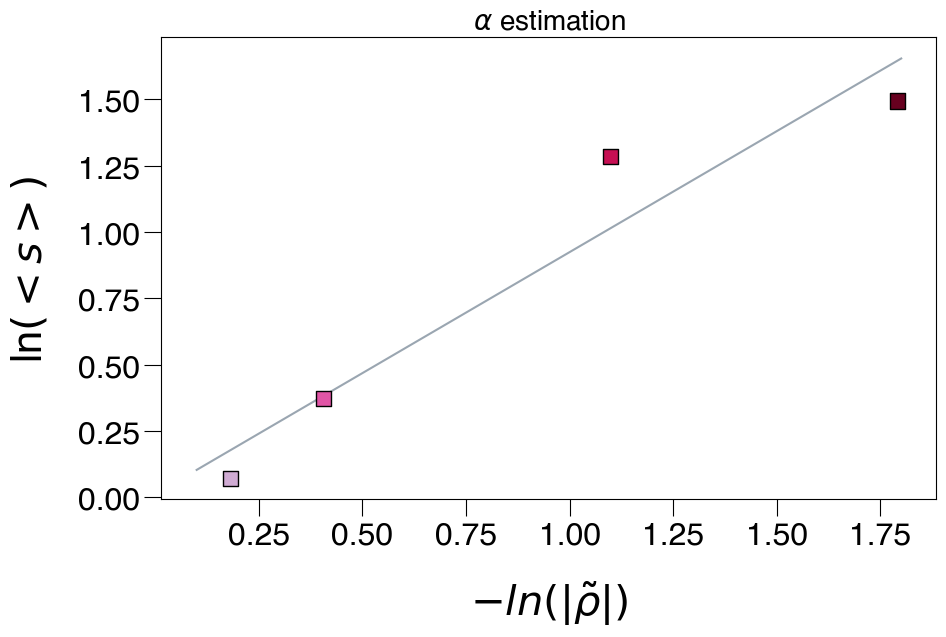

In [23]:
plt.rc('font', family='Helvetica')

y_axis = np.log(np.nanmean(df_dead.iloc[:,1:], axis = 0))
x_axis = np.log(np.abs((np.array(list(k_array_lines_dead[1].keys())).astype(float) - critical_c_dead)/critical_c_dead)[1:])
fig, ax = plt.subplots(figsize=(10, int(0.65 * 10)))
cmap=LinearSegmentedColormap.from_list('rg',['hotpink',  'magenta', 'mediumvioletred',\
     'darkmagenta'], N=256) 
     
n_colors = len(conc_dead[1:])
cmap = matplotlib.cm.get_cmap('PuRd')
rgba_values = [cmap(np.linspace(0.3, 1, n_colors))[i] for i in range(n_colors)]
ax.scatter(-x_axis, y_axis, zorder = 2, s = 120, edgecolor = 'black', color = rgba_values, alpha = 1,\
    marker = 's')
dataToSave = pd.DataFrame({'ln |rho_tilde|':x_axis, 'ln(<s>)':y_axis})


from openpyxl import load_workbook



#ax.set_title("$ \\alpha$ Estimation - $RP_3$", fontsize=30, pad = 20) 
ax.set_xlabel('$-ln(| \\tilde{\\rho}|)$', fontsize = 30, labelpad = 20) 
ax.set_ylabel('ln$(< s >)$', fontsize=30, labelpad = 20) 

popt, pcov = scipy.optimize.curve_fit(lambda x, a, b: a*x + b, x_axis, y_axis) 

print(popt, np.sqrt(pcov[0][0]))
x_axis_line = np.linspace(-1.8, -0.1)
ax.plot(-x_axis_line, x_axis_line * (popt[0]) + popt[1],\
    zorder = 1, label = 'Line with slope $m=-1$', color = 'slategrey', alpha = 0.7) 

#ax.legend(facecolor = 'aliceblue', shadow = True, edgecolor = 'black', fontsize = 15) 
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter()) 
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter()) 
ax.get_xaxis().set_minor_formatter(mpl.ticker.ScalarFormatter()) 
ax.get_yaxis().set_minor_formatter(mpl.ticker.ScalarFormatter()) 
ax.tick_params(axis='both', which='major', labelsize=23, length=12)
ax.set_title('$\\alpha$ estimation', fontsize = 20)

#fig.savefig('../../../Desktop/Fig1B.pdf', dpi = 300, facecolor = 'white', bbox_inches = 'tight')
#fig.savefig('../../../Desktop/Fig1B.svg', dpi = 300, facecolor = 'white')

In [ ]:
writer.close()


In [ ]:
'''
right_phi = 0.9694161305365674
alpha = 1  -0.91215652 /right_phi
m_std = np.sqrt(pcov[0][0])

phi_err = 0.11434548720453037
std_alpha = np.sqrt((1 / right_phi**2)*m_std**2 + ((popt[0]**2 / right_phi**4) )* (phi_err)**2)

print(alpha, 'pm', std_alpha)
'''

"\nright_phi = 0.9694161305365674\nalpha = 1  -0.91215652 /right_phi\nm_std = np.sqrt(pcov[0][0])\n\nphi_err = 0.11434548720453037\nstd_alpha = np.sqrt((1 / right_phi**2)*m_std**2 + ((popt[0]**2 / right_phi**4) )* (phi_err)**2)\n\nprint(alpha, 'pm', std_alpha)\n"

Text(0, 0.5, '$log( \\dfrac{<s^{k+1}>}{<s^{k}>} )$')

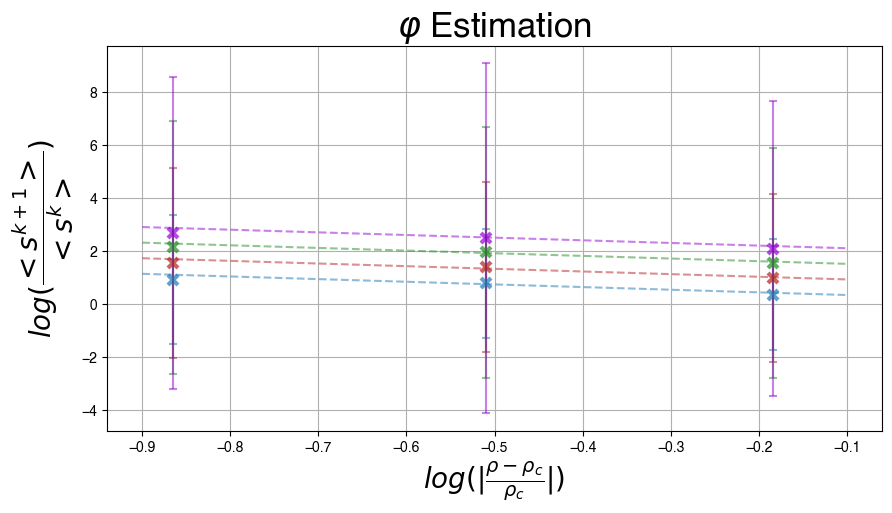

In [24]:
fig, ax = plt.subplots(figsize=(10, 5))
x_axis = np.linspace(-0.9, -0.1, 100)
for i, dict_ in enumerate(ratio_arr_list):
    ax.plot(np.log10(np.array(list(dict_.keys())[2:])), np.log10(np.exp(i)  * np.array(list(dict_.values())[2:])),\
         'x', label = f'k = {k_to_try[i]}', zorder = 4, color = colors[i], alpha = 0.7,\
            markeredgewidth = 3, markersize = 7)
    ax.plot(x_axis, -1 * x_axis + i/1.7 + 0.25, '--', color = colors[i], zorder = 3, alpha = 0.5)

    ax.errorbar(np.log10(np.array(list(dict_.keys())[2:])),\
            np.log10(np.exp(i)  * np.array(list(dict_.values())[2:])),\
            yerr = list(err_dict[k_to_try[i]].values())[2:],\
                zorder = 2, color = colors[i], fmt = 'none', capsize =3, capthick = 1.5, alpha = 0.5)
#ax.legend()

ax.grid(zorder = 1)      
#ax.set_xscale('log')  
#ax.set_yscale('log')  
  
ax.set_title("$ \\varphi$ Estimation", fontsize=25)  
ax.set_xlabel('$log(| \\frac{\\rho - \\rho_{c}}{\\rho_c}|)$', fontsize = 20)  
ax.set_ylabel('$log( \dfrac{<s^{k+1}>}{<s^{k}>} )$', fontsize=20)


## Cumulative analysis

In [25]:
def cumulative_data(array):
    array = np.array(array)
    array = np.sort(array)
    array = array[~np.isnan(array)]
    array = array[array >= 0]
    cumul = 1 - np.arange(0, len(array))/(len(array))
    return array, cumul

In [26]:
dead_cum_dict = {conc: pd.Series(cumulative_data(np.array(df_dead)[:,conc_dead.index(conc)])[1]) for conc in conc_dead}

In [27]:
cmap=LinearSegmentedColormap.from_list('rg',['skyblue',\
     'cornflowerblue', 'royalblue', 'orchid', 'blue', 'navy'], N=256)


n_colors = len(conc_dead)
colors_coll = {conc: cmap(np.linspace(0, 1, n_colors))[i] for i, conc in enumerate(conc_dead)}


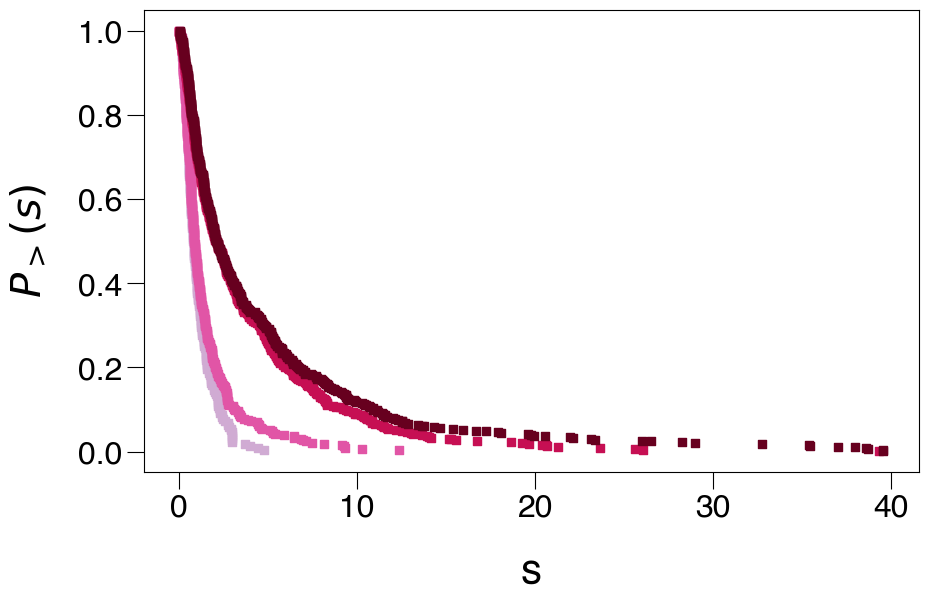

In [28]:
fig, ax = plt.subplots(figsize=(10, int(0.65*10)))

n_colors = len(conc_dead[1:])
cmap = matplotlib.cm.get_cmap('PuRd')
rgba_values = [cmap(np.linspace(0.3, 1, n_colors))[i] for i in range(n_colors)]


for i, conc in enumerate(conc_dead[1:]):
    ax.scatter(cumulative_data(np.array(df_dead)[:,conc_dead.index(conc)])[0],\
         dead_cum_dict[conc], label = f'$RP_3$, {conc}$\\mu M$', 
         s=35, zorder = 4, color = rgba_values[i], marker = 's')

ax.tick_params(axis='both', which='major', labelsize=23, length=12)
#ax.tick_params(axis='both', which='minor', labelsize=12, length=6)
#ax.minorticks_on()

ax.set_xlabel('s', fontsize = 30, labelpad=20)
ax.set_ylabel('$P_>(s)$', fontsize = 30, labelpad=20)
#ax.set_title('Survival Probability Distribution - $RP_3$', fontsize = 20)

#ax.grid(zorder=1)

#ax.legend(facecolor = 'aliceblue', fontsize = 12, shadow = True, edgecolor = 'black')

#ax.grid(zorder = 1)
plt.show()

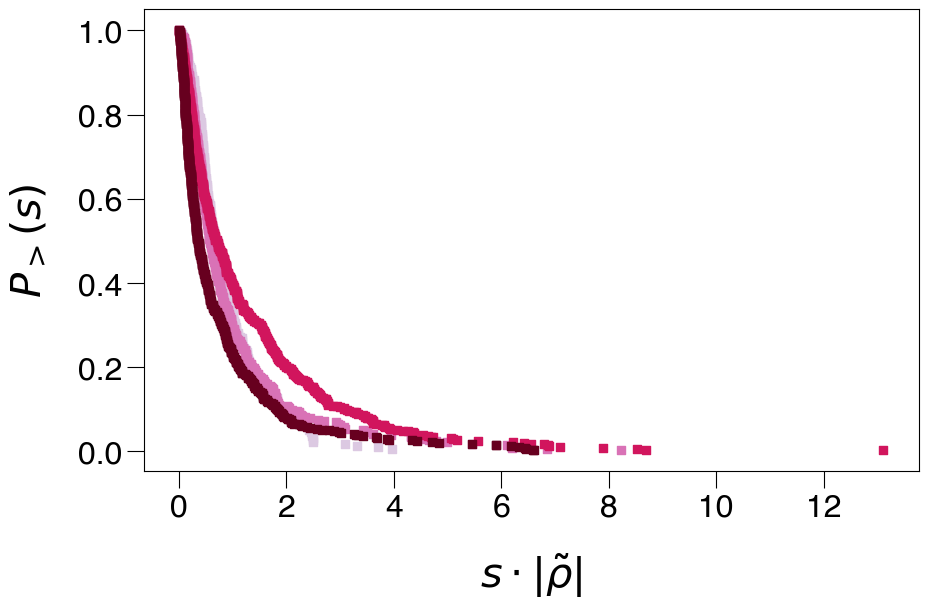

In [29]:
fig, ax = plt.subplots(figsize=(10, int(10 * 0.65)))
critical_c_dead = 40
n_colors = len(conc_dead[1:])
cmap = matplotlib.cm.get_cmap('PuRd')
rgba_values = [cmap(np.linspace(0.2, 1, n_colors))[i] for i in range(n_colors)]

for i, conc in enumerate(conc_dead[1:]):
    dataToSave = pd.DataFrame({'s * |rho_tilde|':cumulative_data(np.array(df_dead)[:,conc_dead.index(conc)])[0] * \
        np.abs(((float(conc) - critical_c_dead) / critical_c_dead)),'P>(s)':dead_cum_dict[conc]})
    ax.scatter(cumulative_data(np.array(df_dead)[:,conc_dead.index(conc)])[0] * \
        np.abs(((float(conc) - critical_c_dead) / critical_c_dead)),\
         dead_cum_dict[conc], label = f'$RP_3$, {conc}$\mu M$',\
             color = rgba_values[i], marker = 's', s = 35)
    book = load_workbook('../../siData.xlsx')
    writer = pd.ExcelWriter('../../siData.xlsx', engine = 'openpyxl', mode='a')
    writer.book = book
    dataToSave.to_excel(writer, sheet_name = f'FigSI2A{conc}', index = False)
    writer.close()

ax.tick_params(axis='both', which='major', labelsize=23, length=12)
#ax.tick_params(axis='both', which='minor', labelsize=12, length=6)
#ax.minorticks_on()

ax.set_xlabel('$s \cdot |\\tilde{\\rho}|$', fontsize = 30, labelpad = 20)
ax.set_ylabel('$P_>(s)$', fontsize = 30, labelpad = 20)
#ax.set_title('Survival Probability Distribution - $RP_3$', fontsize = 20)

#ax.grid(zorder=1)

#ax.legend(facecolor = 'aliceblue', fontsize = 12, shadow = True, edgecolor = 'black')


#fig.savefig('../../paperPlots/pdfPlots/FigS2a.pdf', dpi = 300, facecolor = 'white', bbox_inches = 'tight')
#fig.savefig('../../paperPlots/svgPlots/FigS2a.svg', dpi = 300, facecolor = 'white')
plt.show()


Text(0, 0.5, '$P_>(s)$')

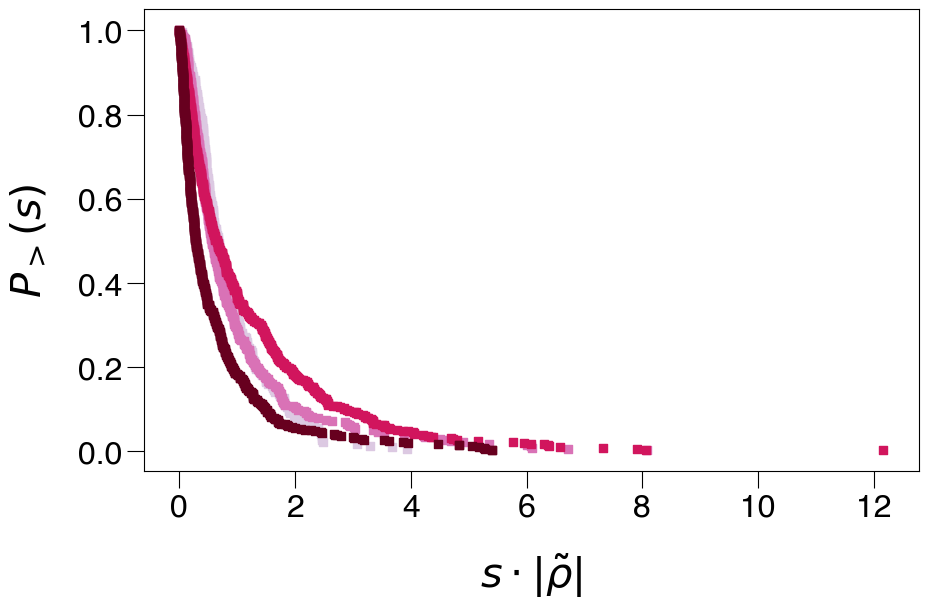

In [31]:
fig, ax = plt.subplots(figsize=(10, int(10*0.65))) 
 
 
 
n_colors = len(conc_dead[1:])
cmap = matplotlib.cm.get_cmap('PuRd')
rgba_values = [cmap(np.linspace(0.2, 1, n_colors))[i] for i in range(n_colors)]
for i, conc in enumerate(conc_dead[1:]): 
    dataToSave = pd.DataFrame({'s * |rho_tilde|':cumulative_data(np.array(df_dead)[:,conc_dead.index(conc)])[0] * \
        np.abs(((float(conc) - critical_c_dead) / critical_c_dead)),'P>(s)':dead_cum_dict[conc]})
    ax.scatter(cumulative_data(np.array(df_dead)[:,conc_dead.index(conc)])[0] * \
        np.abs(((float(conc) - final_rho_c_dead) / final_rho_c_dead)),\
            dead_cum_dict[conc], label = f'$RP_3$, {conc}$\\mu M$',\
                zorder = 4, marker = 's', s=35, color = rgba_values[i]) 
    book = load_workbook('../../siData.xlsx')
    writer = pd.ExcelWriter('../../siData.xlsx', engine = 'openpyxl', mode='a')
    writer.book = book
    dataToSave.to_excel(writer, sheet_name = f'FigSI2B{conc}', index = False)
    writer.close()
 
ax.tick_params(axis='both', which='major', labelsize=23, length=12) 
#ax.tick_params(axis='both', which='minor', labelsize=12, length=6) 
#ax.minorticks_on() 
 
ax.set_xlabel('$s \cdot | \\tilde{\\rho}|$', fontsize = 30 , labelpad=20) 
ax.set_ylabel('$P_>(s)$', fontsize = 30 , labelpad=20) 
#ax.set_title('Survival Probability Distribution - $RP_3$', fontsize = 20) 
 
#ax.grid(zorder=1) 
 
#ax.legend(facecolor = 'aliceblue', fontsize = 12, shadow = True, edgecolor = 'black') 
 
 
#fig.savefig('../../paperPlots/pdfPlots/FigS2b.pdf', dpi = 300, facecolor = 'white', bbox_inches = 'tight') 
#fig.savefig('../../paperPlots/svgPlots/FigS2b.svg', dpi = 300, facecolor = 'white')